# Action Calculation Accuracy
This is a notebook for evaluating the accuracy of our action calculation

This notebook is here for verification purposes and it is not recommended that you deal with this unless you are really interested in the details

For orbits in a spherical potential the action is given by

$$
\begin{align}
J_r(E,L) &= \frac{1}{\pi} \int_{r_{\rm{p}}}^{r_{\rm{a}}} \sqrt{2(E - \phi_{\rm{eff}}(E, L))} \rm{d}r \\
\phi_{\rm{eff}}(r,L) &= \phi(r) + \frac{L^2}{2 r^2}
\end{align}
$$

Here we will
- Create a particle realization of an NFW halo
- Calculate the radial actions with galpy
- Calculate the radial actions with our code at different accuracies
- Compare the accuracies and the performance

&rarr; Our implementation of the action integration is very quick and highly vectorized. It has already good enough relative accuracy ($10^{-3}$) at only 50 integration steps. At this level it is a few hundred times faster than galpy.

## Requirements:
To install galpy:

conda install galpy -c conda-forge

## More:
To see, how we calculate the actions check out the following function inside the code:
```
adiabatic_tides.profiles.RadialProfile.radial_action()
```

In [1]:
%matplotlib inline
import sys
import numpy as np
import time
import matplotlib.pyplot as plt

from galpy import potential
from galpy.df import isotropicNFWdf
from galpy.orbit import Orbit
from galpy.util import conversion

sys.path.append("../..")
import adiabatic_tides as at

## Sample some particles of an NFW halo

In [2]:
np.random.seed(41)
prof_nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)

pos,vel,mass = prof_nfw.sample_particles(ntot=1000)

# galpy sometimes gets unbound particle orbit errors 
#(allthough the orbits are bound, just with a very large apocenter)
# so we just decrease the velocity of our testparticles a bit to facilitate comparison
vel *= 0.8

## Calculate their actions with Galpy

In [3]:
def galpy_orbits_from_xyz(x, v): 
    R = np.sqrt(x[...,0]**2 + x[...,1]**2)
    phi = np.arctan2(x[...,1], x[...,0])
    vR = np.sum(x[...,0:2]*v[...,0:2], axis=-1) / R
    vT = np.cross(x, v)[...,2] / R
    
    return Orbit(np.stack([R,vR,vT,x[...,2],v[...,2],phi],axis=-1))

galpy_nfw = potential.NFWPotential(conc=6., mvir=prof_nfw.m200c / 1e12, wrtcrit=True, H=67.9)
galpy_orbits = galpy_orbits_from_xyz(pos *1e3 / conversion.parse_length_kpc(8), vel / conversion.parse_velocity_kms(220.))
galpy_jr = galpy_orbits.jr(pot = galpy_nfw)
galpy_unitfac = conversion.parse_length_kpc(8) * conversion.parse_velocity_kms(220.) / 1e3

## Check against the actions calculated with our code for different number of integration points

(1e-07, 0.1)

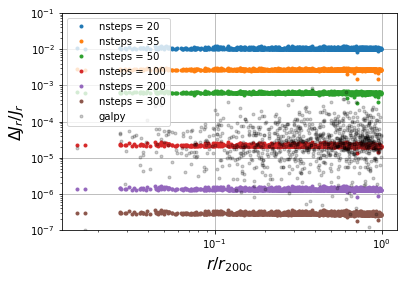

In [4]:
xval = np.sqrt(np.sum(pos**2, axis=-1)) / prof_nfw.r200c

jrref = prof_nfw.radial_action((pos, vel), nbins=int(1e4)) # High accuracy reference action
for nsteps in 20,35,50,100,200,300:
    jr = prof_nfw.radial_action((pos, vel), nbins=nsteps)
    plt.loglog(xval, np.abs(1.-jr/jrref), marker=".", linestyle="none", label="nsteps = %d" % nsteps)
plt.loglog(xval, np.abs(1.-galpy_unitfac*galpy_jr/jrref), marker=".", linestyle="none", label="galpy", color="black", alpha=0.2)
    
plt.legend(fontsize=10)
plt.grid()
plt.ylabel(r"$\Delta J_r / J_r$", fontsize=16)
plt.xlabel(r"$r / r_{\rm{200c}}$", fontsize=16);
plt.ylim(1e-7, 1e-1)

# Action Calculation Speed

In [5]:
np.random.seed(40)
prof_nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)
pos,vel,mass = prof_nfw.sample_particles(ntot=100000)
vel *= 0.8

for nsteps in 10,30,50,100,300,1000:
    t0 = time.time()
    jr = prof_nfw.radial_action((pos, vel), nbins=nsteps)
    print("nsteps = %d,  %.3f seconds" % (nsteps, time.time() - t0))

nsteps = 10,  0.484 seconds
nsteps = 30,  0.692 seconds
nsteps = 50,  1.067 seconds
nsteps = 100,  2.251 seconds
nsteps = 300,  5.959 seconds
nsteps = 1000,  19.315 seconds


In [6]:
# Warning: executing this cell takes forever (15 minutes or so)
galpy_orbits = galpy_orbits_from_xyz(pos *1e3 / conversion.parse_length_kpc(8), vel / conversion.parse_velocity_kms(220.))
t0 = time.time()
galpy_jr = galpy_orbits.jr(pot = galpy_nfw)
print("galpy,  %.2f seconds" % (time.time() - t0))

/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:245: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.162252e-04
  warnings.warn(

/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:245: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.400596e-06
  warnings.warn(

/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:245: AccuracyWarning: maxiter (50) exceeded. Latest difference = 4.213536e-07
  warnings.warn(

/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/galpy/actionAngle/actionAngleSpherical.py:546: RuntimeWarning: invalid value encountered in sqrt
  return numpy.sqrt(2.*(E-potentialAxi(r,pot))-L**2./r**2.)

/scratch/stuecker/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/integrate/_quadrature.py:245: AccuracyWarning: maxiter (50) exceeded. Latest difference = nan
  warnings.